In [1]:
from collections import Counter, defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
project_path = Path("/projects/b1171/ylk4626/project/Chimera")

In [3]:
def read_sv_annotation(file):
    """Read the SV annotation file and return a dictionary with the SVs as keys and the annotations as values."""
    result = defaultdict(list)
    with Path.open(file) as f:
        lines = f.readlines()

        for line in lines[1:]:
            dvcf, sv, sp, *lefts = line.split()
            result[int(sp)].append([sv, lefts[-1]])
    return result

def collect_inv_length(file):
    """Read the inversion annotation file and return a dictionary with the inversions as keys and the annotations as values."""
    result = []
    with Path.open(file) as f:
        lines = f.readlines()
        for line in lines[1:]:
            dvcf, inv, sp, *lefts = line.split()
            content = inv.split(":")
            if content[0] == "INV":
                chrom = content[1]
                if chrom.startswith("chr"):
                    bp1, bp2 = content[2].split("-")
                    length = int(bp2) - int(bp1)
                    result.append(abs(length))
    return result

# Determine the threshold for diff of inv bounary 

In [15]:
inv_length = collect_inv_length(
    project_path / "data/sv/PC3_10_cells_MDA_P2_dirty/chimeric_reads_mapping/updated_SVCF/cutesv.annotated_sv_1000.tsv"
)

In [16]:
len(inv_length)

525064

In [19]:
inv_length[:10]

[402, 981, 621, 188, 182, 576, 395, 117, 541, 435]

In [57]:
def draw_inv_length(data):
    """Draw a histogram of the inversion lengths."""
    # draw two figures one is histogram, the other is boxplot

    figs, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs = axs.flatten()

    sns.histplot(data, bins=100, log_scale=True, ax=axs[0])
    plt.xlabel("Inversion Length")
    plt.ylabel("Count")
    plt.title("Inversion Length Distribution")

    # get mean and median, and quantiles
    mean = sum(data) / len(data)
    median = sorted(data)[len(data) // 2]
    q1 = sorted(data)[len(data) // 4]
    q3 = sorted(data)[3 * len(data) // 4]
    axs[0].axvline(mean, color="red", linestyle="--", label=f"Mean: {mean:.2f}")
    axs[0].axvline(median, color="green", linestyle="--", label=f"Median: {median:.2f}")
    axs[0].axvline(q1, color="blue", linestyle="--", label=f"Q1: {q1:.2f}")
    axs[0].axvline(q3, color="purple", linestyle="--", label=f"Q3: {q3:.2f}")

    suggestions = {
        "strict": int(min(100, median * 0.05)),  # 5% of the median
        "moderate": int(min(500, median * 0.1)),  # 10% of the median
        "relaxed": int(min(1000, median * 0.15)),  # 20% of the median
    }
    print(suggestions)

    # calculate 95% confidence interval of the inversion length
    lower = sorted(data)[int(len(data) * 0.025)]
    upper = sorted(data)[int(len(data) * 0.975)]
    axs[0].axvline(lower, color="orange", linestyle="--", label=f"Lower: {lower:.2f}")
    axs[0].axvline(upper, color="orange", linestyle="--", label=f"Upper: {upper:.2f}")
    axs[0].legend()

    sns.boxplot(data, ax=axs[1], log_scale=True)
    plt.xlabel("Inversion Length")
    plt.title("Inversion Length Distribution")

    # I want to determine a threshold to calculate the overlapping between two inversions (one inversion is a interval [start, end])
    # show me some suggestinos how to determine the threshold

    plt.show()

{'strict': 22, 'moderate': 45, 'relaxed': 67}


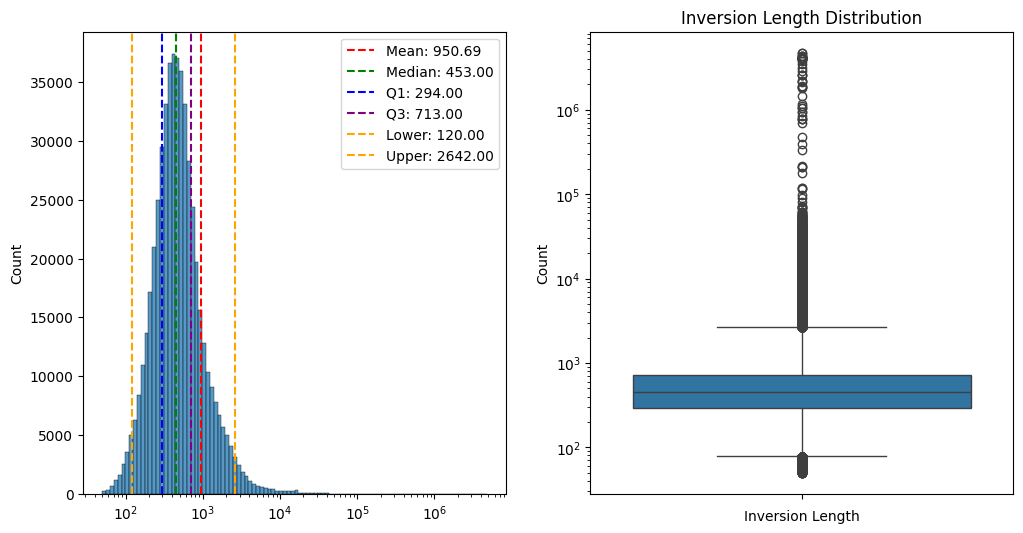

In [58]:
draw_inv_length(inv_length)


**Mathematical Justification:**

1. **MAD-based Thresholds**:
   - Uses Median Absolute Deviation: `MAD = median(|Xi - median(X)|)`
   - For normal distributions: `σ ≈ 1.4826 * MAD`
   - Thresholds based on standard normal quantiles:
     - Strict: `0.6745 * MAD` (50% confidence)
     - Moderate: `1.4826 * MAD` (68% confidence)
     - Relaxed: `2.9652 * MAD` (95% confidence)

2. **Standard Deviation Based**:
   - Uses classical standard deviation
   - Based on normal distribution properties:
     - Strict: `0.67σ` (~50% of data)
     - Moderate: `1σ` (~68% of data)
     - Relaxed: `2σ` (~95% of data)

3. **Percentile Based**:
   - Non-parametric approach
   - Uses actual data distribution
   - Takes 5% of different quartiles

**Why These Methods?**

1. **MAD-based** is robust to outliers and preferred when:
   - Data has outliers
   - Distribution is heavy-tailed
   - Need stable thresholds

2. **STD-based** is traditional and good when:
   - Data is approximately normal
   - Want to use well-understood statistical properties
   - Have clean data without major outliers

3. **Percentile-based** is distribution-agnostic and preferred when:
   - Data is not normally distributed
   - Want to avoid assumptions about distribution
   - Need robust thresholds based on actual data shape

The choice between these methods depends on:
1. Your data distribution (check Q-Q plot)
2. Presence of outliers
3. Required statistical confidence
4. Biological meaning of the thresholds

I recommend:
1. Check the Q-Q plot to understand your data distribution
2. If approximately normal: use STD-based
3. If heavy-tailed or with outliers: use MAD-based
4. If neither fits well: use percentile-based

This approach provides statistically justified thresholds with clear confidence levels and assumptions.


In [66]:
def calculate_statistical_thresholds(inv_lengths):
    """Calculate thresholds based on statistical properties of the data.

    Args:
        inv_lengths (list): List of inversion lengths

    Returns:
        dict: Different thresholds with statistical justification
    """
    # Convert to numpy array for calculations
    lengths = np.array(inv_lengths)

    # Basic statistics
    median = np.median(lengths)
    mad = np.median(np.abs(lengths - median))  # Median Absolute Deviation
    std = np.std(lengths)

    # Calculate thresholds based on different statistical principles
    return {
        # Based on MAD (robust to outliers)
        "mad_based": {
            "strict": int(0.6745 * mad),  # ~50% confidence interval for normal distribution
            "moderate": int(1.4826 * mad),  # ~68% confidence interval (1 sigma equivalent)
            "relaxed": int(2.9652 * mad),  # ~95% confidence interval (2 sigma equivalent)
        },
        # Based on standard deviation
        "std_based": {
            "strict": int(std * 0.67),  # ~50% confidence interval
            "moderate": int(std),  # ~68% confidence interval
            "relaxed": int(std * 2),  # ~95% confidence interval
        },
        # Based on percentiles (non-parametric)
        "percentile_based": {
            "strict": int(np.percentile(lengths, 25) * 0.05),  # 5% of Q1
            "moderate": int(np.percentile(lengths, 50) * 0.05),  # 5% of median
            "relaxed": int(np.percentile(lengths, 75) * 0.05),  # 5% of Q3
        },
    }



def analyze_threshold_distribution(inv_lengths):
    """Analyze and visualize threshold distribution.

    Args:
        inv_lengths (list): List of inversion lengths
    """
    thresholds = calculate_statistical_thresholds(inv_lengths)

    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Length distribution with thresholds
    sns.histplot(inv_lengths, bins=100, log_scale=True, ax=axes[0])

    # Add threshold lines for each method
    colors = {"mad_based": "red", "std_based": "blue", "percentile_based": "green"}
    styles = {"strict": ":", "moderate": "--", "relaxed": "-"}

    for method, color in colors.items():
        for level, style in styles.items():
            threshold = thresholds[method][level]
            axes[0].axvline(threshold, color=color, linestyle=style, label=f"{method}-{level}: {threshold}")

    axes[0].set_title("Inversion Length Distribution with Statistical Thresholds")
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Plot 2: QQ plot to check normality
    from scipy import stats

    stats.probplot(np.log10(inv_lengths), dist="norm", plot=axes[1])
    axes[1].set_title("Q-Q Plot of Log10 Inversion Lengths")

    plt.tight_layout()
    plt.show()

    return thresholds



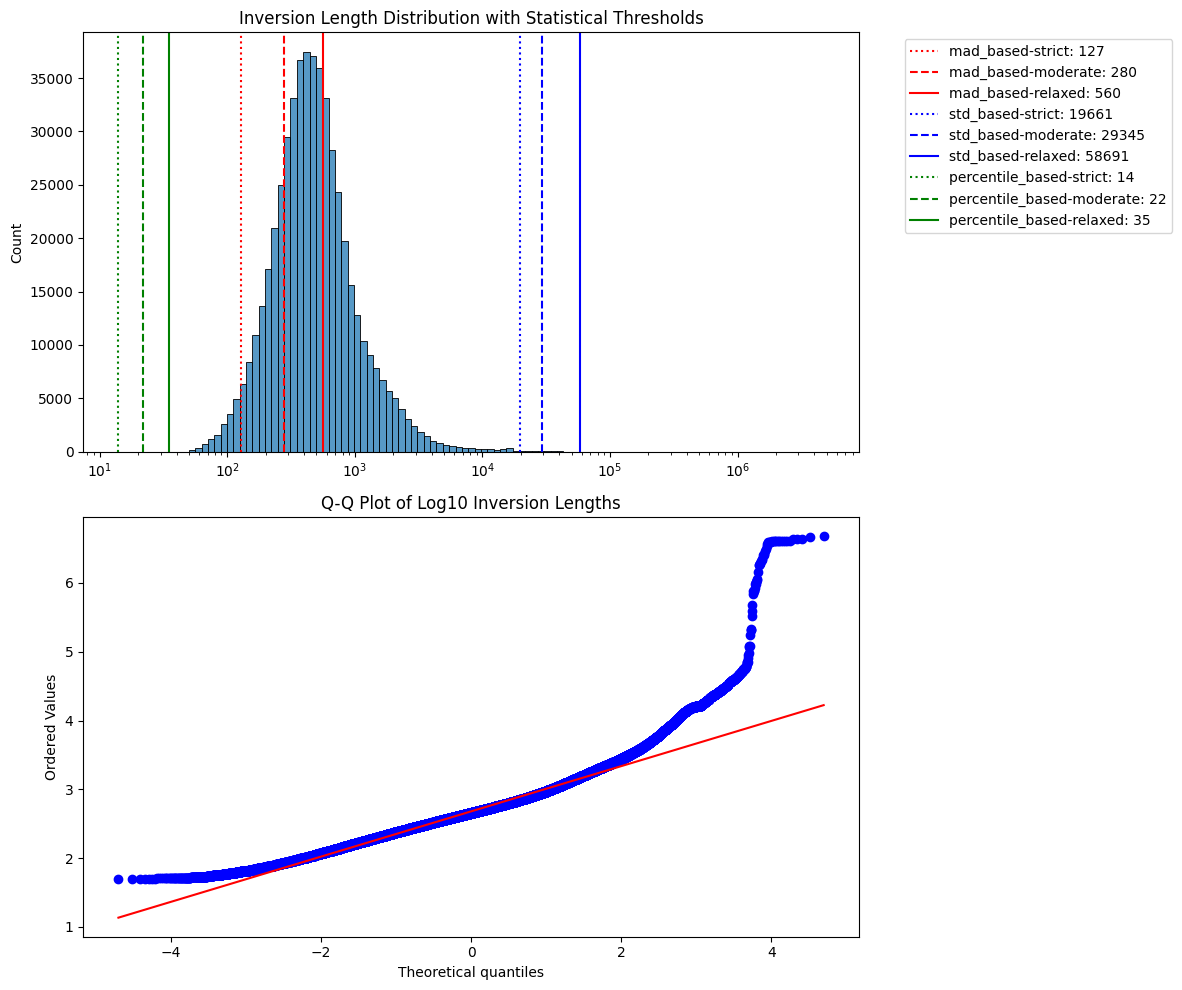

In [67]:
# Analyze the data
thresholds = analyze_threshold_distribution(inv_length)

**The distribution of inversion lengths does not follow a normal distribution but exhibits a heavy tail. Therefore, we decided to use the MAD-based threshold approach. Additionally, considering that clean data typically contains only hundreds of inversions in total, we selected a strict threshold of 127.**

# Collect read names of inversions from the training data

In [5]:
t127_result = read_sv_annotation(project_path/"data/sv/PC3_10_cells_MDA_P2_dirty/chimeric_reads_mapping/updated_SVCF/cutesv.annotated_sv_127.tsv")

In [6]:
t127_result.keys()

dict_keys([0, 2, 1, 3])

In [7]:
t127_result

defaultdict(list,
            {0: [['TRA:chr1:40364172-32435379',
               '4b9cabc9-0ada-407f-81c7-dc3cf4ec2833,59832234-81f4-447e-9493-04336f7f6787,936da1a9-8ac1-4fdb-aaa8-a4c5c79a46cf,2cbcf005-6032-4819-b0d2-bea28af9553c,fc894e44-4a29-4f3d-9c39-d93eae8eb86f,43be2ad0-f528-45ba-ad33-48c3fd28fc6d,c4d796ab-c561-40f9-bb85-c5c5269058c5,d0b778c7-820b-42c3-8021-e20838060417,463aab56-3c44-49b8-b65f-8e754023ed6c,b2a7dfb1-fc61-4d3a-b3f3-af5d07b6a3e1,36453a98-a778-4507-8cfa-208af2d10470,9e7b0344-61e5-4ae1-b495-994b2f29e2d8,3a9ef674-248a-4201-b056-1415978aee9e,1c8db978-dacc-4cbd-bb97-25a4dea4231b,f6f14a18-1959-43c1-96b4-ea60170aa502,b5abdc2c-747a-4fdc-b2f7-d61887034e00,17c4f7d8-1004-4cb8-be29-fe226e36afa5,3b06c566-86c2-4e59-9995-e2f6f5c3d1c3,a4de4288-596e-4fe9-9891-607f22a0a7f1'],
              ['TRA:chr1:40364173-32435380',
               'd6f5db16-be44-4e20-9812-6cf253d60c22_1,fb182863-76c2-40a9-9355-eb492bf48b1e,8a071baf-8dfc-4e47-a712-5bdb6aee3579,a8b7f4be-18f8-4f77-b24c-1c3ca9bed0c6,3

In [74]:
def draw_bar(data):
    plot_data = {k: len(v)  for k,v in data.items()}
    print(plot_data)
    sns.barplot(plot_data)

{0: 536416, 2: 1943, 1: 3928, 3: 68}


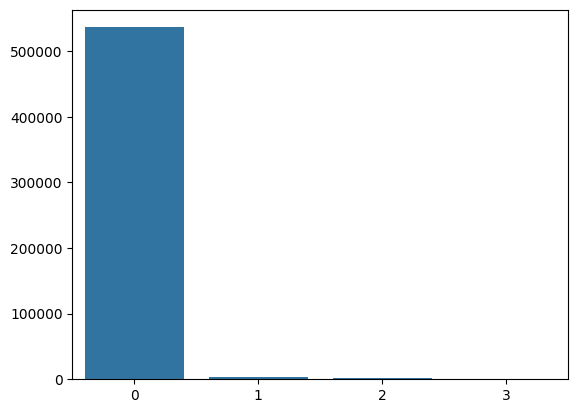

In [75]:
draw_bar(t127_result)

In [10]:
def get_reads_for_inv(data):
    """Get the reads for inversions."""
    plot_data = defaultdict(list)

    for k, vs in data.items():
        for v in vs:
            sv_type = v[0].split(":")[0]
            if sv_type == "INV":
                plot_data[k].extend(v[1].split(","))
    return plot_data

In [11]:
reads_for_inv = get_reads_for_inv(t127_result)

In [12]:
# use comma to split the numbers in string
print(f"{len(reads_for_inv[0])} reads for inversion 0") # noq: E999

2243264 reads for inversion 0


In [13]:
def draw_bar_hue_by_sv_type(data):
    plot_data = defaultdict(list)

    for k,vs in data.items():
        for v in vs:
            plot_data[k].append(v[0].split(":")[0])

    return {k: Counter(v) for k,v in plot_data.items()}

In [14]:
draw_bar_hue_by_sv_type(t127_result)

{0: Counter({'INV': 521950,
          'DEL': 6583,
          'INS': 4240,
          'TRA': 1902,
          'DUP': 1741}),
 2: Counter({'INV': 1552, 'DEL': 169, 'TRA': 94, 'INS': 93, 'DUP': 35}),
 1: Counter({'INV': 3170, 'DEL': 321, 'INS': 263, 'TRA': 142, 'DUP': 32}),
 3: Counter({'TRA': 18, 'DEL': 15, 'INV': 14, 'INS': 13, 'DUP': 8})}

In [15]:
def summary_inv_for_all_threshold():
    """Summarize the inversions for all thresholds."""
    tresholds = [100,127, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]
    results   = []
    reads_for_inv = []
    for t in tresholds:
        odata = read_sv_annotation(project_path/f"data/sv/PC3_10_cells_MDA_P2_dirty/chimeric_reads_mapping/updated_SVCF/cutesv.annotated_sv_{t}.tsv")
        results.append(draw_bar_hue_by_sv_type(odata))
        reads_for_inv.append(get_reads_for_inv(odata))

    inv_with_sp0 = [res[0]['INV'] for res in results]
    return inv_with_sp0, reads_for_inv

In [16]:
inv_with_sp0_all_thresholds, reads_for_inv_all_thresholds = summary_inv_for_all_threshold()

: 

In [104]:
inv_with_sp0_all_thresholds

[522077,
 521782,
 521724,
 521579,
 521421,
 521243,
 521061,
 520916,
 520766,
 520600,
 520450]

<Axes: >

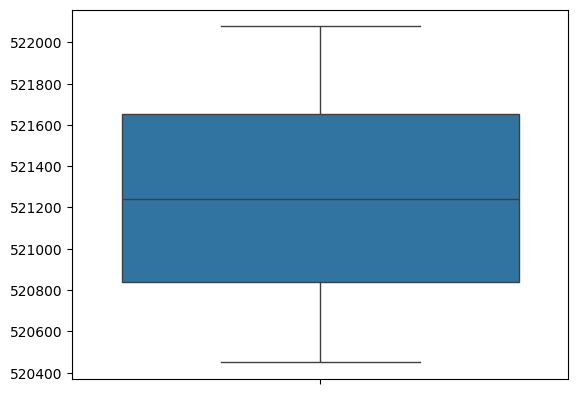

In [106]:
sns.boxplot(inv_with_sp0_all_thresholds)

In [102]:
reads_for_inv_all_thresholds

[defaultdict(list,
             {0: ['37ff563a-4063-45e2-b6bc-2ff9aeb40cd8',
               'b988329c-b30e-4b41-8805-875928878c85',
               'e6432c32-a2c3-44b8-99a9-44efc0690a69',
               '2b6e22d5-7040-4f66-96f4-51681f100dfa',
               'e1ef5cbe-7b7b-423d-99a8-f96e0010dc5a',
               '10e07a16-58de-4e5c-b723-65a1fa316910',
               'abe570a3-360f-4186-ab60-7453bcde5d47',
               'd9513bf4-81af-4c33-b38c-a5bc62d0cb85',
               'd59a4f17-4f55-47e2-8d18-e63cf214f434',
               'a630f1c4-4b80-4f51-a3e2-ab1c06015e00',
               'b70bf340-bcdc-4ec8-a11b-a00ed2c068db',
               '27f072e7-97bf-40d4-9e53-671738fcfd3b',
               'df0895d3-f8ef-4f5a-8f2d-4eeaf259fdd4',
               'd7f07267-c59e-4b71-b48a-61ca4f07c96f',
               'c0a568be-4261-4109-9c7a-2268b41400a6',
               '1f3b1b72-babf-438b-918e-f3840954aa2d',
               '7a01e454-b2c7-4341-9057-b9e845da47b9',
               'b2e4fb49-0026-4d0c-b9ac-c72

(500000.0, 530000.0)

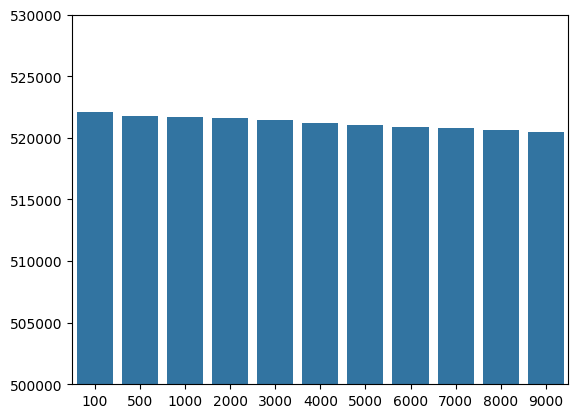

In [105]:
sns.barplot(x=[100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000], y = inv_with_sp0_all_thresholds)
plt.ylim(500000, 530000)

In [ ]:
sns.barplot(x=[100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000], y = [len(i[0]) for i in reads_for_inv_all_thresholds])

In [56]:
def plot1(data):
    # Create a list of records for the DataFrame
    records = []
    for category, sv_counts in data.items():
        for sv_type, count in sv_counts.items():
            records.append({
                'Category': f'Category {category}',
                'SV Type': sv_type,
                'Count': count
            })

    df = pd.DataFrame(records)

    # Set the style and figure size
    plt.figure(figsize=(12, 6))

    # Create the grouped bar plot
    sns.barplot(data=df, x='Category', y='Count', hue='SV Type', palette='husl')

    # Customize the plot
    plt.title('Distribution of SV Types Across Categories', fontsize=14, pad=15)
    plt.xlabel('Category', fontsize=12)

    # Use log scale for y-axis due to large value differences
    # plt.yscale('log')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0)

    # Adjust legend position
    plt.legend(title='SV Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    sns.despine()
    # Adjust layout to prevent label cutoff
    plt.tight_layout()


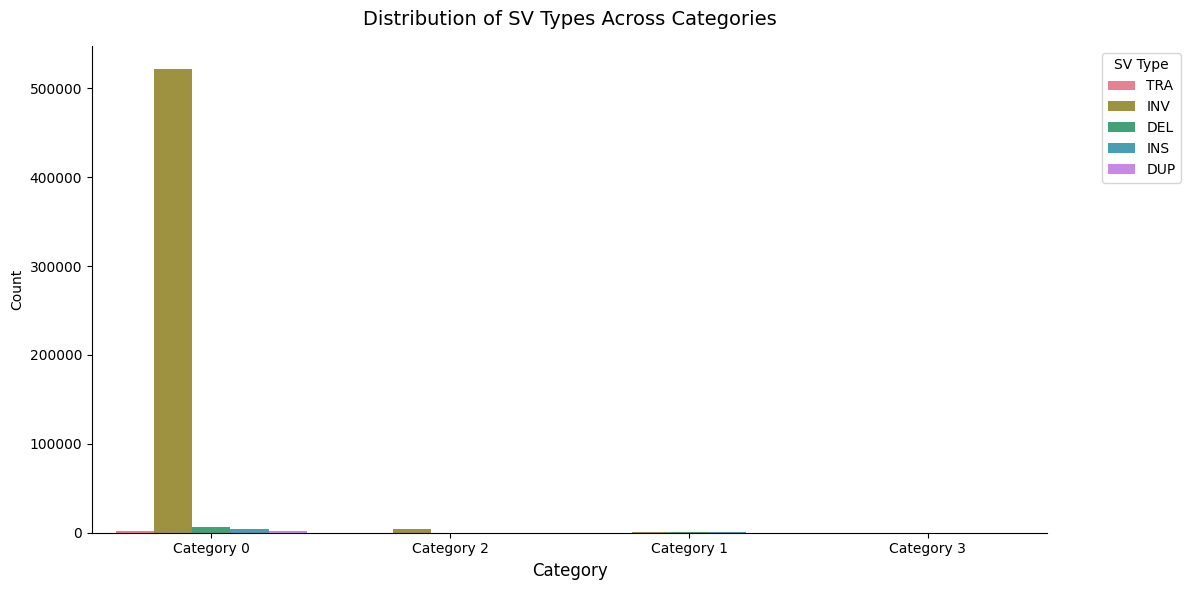

In [57]:
plot1(draw_bar_hue_by_sv_type(t1000_result))

In [94]:
def get_read_vs_inv_with_sup(data, sup=0):
    result = defaultdict(list)

    for k, vs in data.items():
        if k == sup:
            for  v in vs:
                sv_type = v[0].split(":")[0]
                if sv_type == "INV":
                    # plot_data[k].extend(v[1].split(","))
                    reads = v[1].split(",")
                    for read in reads:
                        result[read] = v[0]
    return result

In [95]:
read_vs_inv_with_sup0 = get_read_vs_inv_with_sup(t1000_result)

In [97]:
len(read_vs_inv_with_sup0)

2240503

In [109]:
def write_read_vs_inv_with_sup0(data, file, filter_chrom=True):
    with open(file, "w") as f:
        for read, sv in data.items():
            chrom = sv.split(":")[1]
            if filter_chrom:
                if chrom.startswith("chr"):
                    f.write(f"{read}\t{sv}\n")
            else:
                f.write(f"{read}\t{sv}\n")


In [110]:
write_read_vs_inv_with_sup0(read_vs_inv_with_sup0, project_path/"reads_inv_with_sp0_t1000.txt")

In [148]:
def get_chrom_distribution_inv_len(data, filter_chrom=True):
    from collections import Counter
    chrom_distribution = []
    inv_len = []
    sups_reads_number = []

    for svs in data:
        sv = svs[0]
        reads_count = len(svs[1].split(","))
        svtype, chrom, bps  = sv.split(":")
        bp1, bp2 = bps.split('-')
        if svtype == "INV":
            if filter_chrom:
                if chrom.startswith("chr"):
                    chrom_distribution.append(chrom)
                    inv_len.append(abs(int(bp1) - int(bp2)))
                    sups_reads_number.append(reads_count)

            else:
                chrom_distribution.append(chrom)
                inv_len.append(abs(int(bp1) - int(bp2)))
                sups_reads_number.append(reads_count)

    return Counter(chrom_distribution), inv_len, sups_reads_number

In [140]:
chrom_distribution,sv_len, sups_reads_number = get_chrom_distribution_inv_len(t1000_result[0])

In [141]:
chrom_distribution

Counter({'chr7': 52047,
         'chr1': 42805,
         'chr8': 39103,
         'chr10': 35189,
         'chr5': 31867,
         'chr3': 31717,
         'chr6': 29710,
         'chr14': 26246,
         'chr17': 25934,
         'chr11': 25410,
         'chr2': 25058,
         'chr12': 20951,
         'chr4': 20058,
         'chr9': 18187,
         'chr19': 17100,
         'chr20': 14730,
         'chr18': 14042,
         'chr15': 11842,
         'chrX': 10455,
         'chr16': 10402,
         'chr13': 8340,
         'chr21': 6109,
         'chr22': 2811,
         'chrY': 5})

In [143]:
sum(chrom_distribution.values())

520118

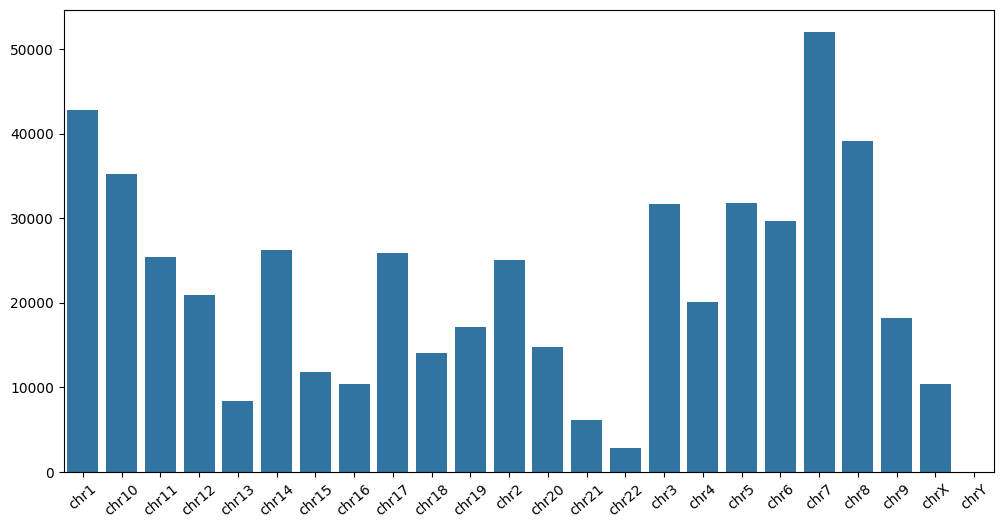

In [142]:

# Set the style and figure size
plt.figure(figsize=(12, 6))
sns.barplot(chrom_distribution)
_ = plt.xticks(rotation=40)

In [145]:
len(sv_len)

520118

<Axes: ylabel='Density'>

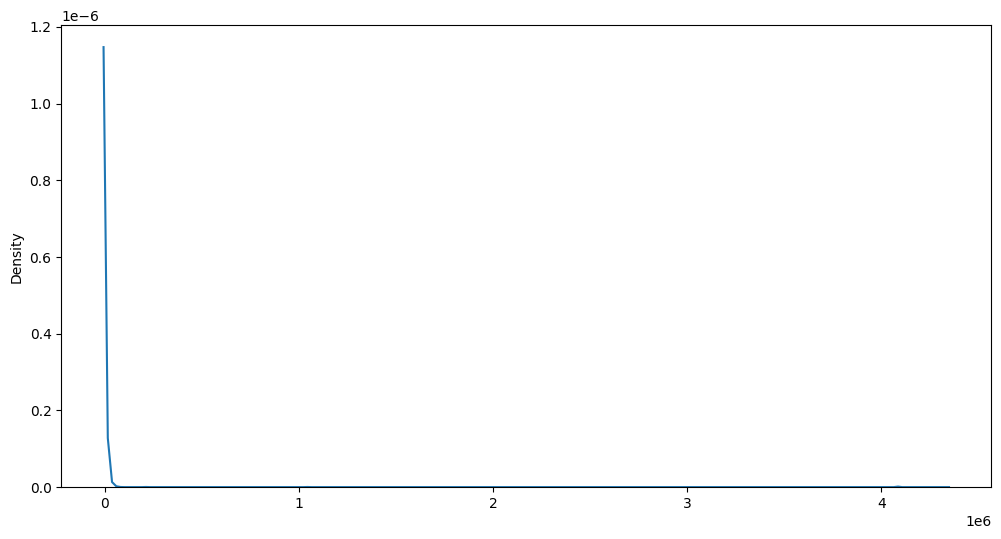

In [149]:
# Set the style and figure size
plt.figure(figsize=(12, 6))
sns.kdeplot(sv_len)